# Data Mining project

### Clustering of countries for COVID-19 cases based on disease prevalence, health systems and environmental indicators

Authors: Inga Wohlert, Nicolas Pablo Viola, Jakob Nyström

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
import jupyter_black
jupyter_black.load()

## 1. Data loading and preprocessing

In [ ]:
def load_and_merge_data():
    """
    Loads and merges the three datasets used for the clustering.
    Also ensures that the country column (which is the join key)
    is consistently represented.

    Returns:
        df_data: Dataframe that contains all columns from the
            original datasets.
    """

    # Import EPI data
    df_epi = pd.read_excel("data/epi_data2.xlsx")

    # Import COVID and socioeconomic data
    df_covid_socio = pd.read_csv("data/Consolidated_COVID_Socioeconomics.csv")
    df_covid_socio = df_covid_socio.rename(
        columns={col: col.lower() for col in df_covid_socio.columns}
    )
    df_disease = pd.read_csv("data/diseases.csv")

    # Ensure that countries have consistent naming by renaming
    # countries in the COVID and socioeconomic dataset
    country_map = {
        "Egypt, Arab Rep.": "Egypt",
        "Iran, Islamic Rep.": "Iran",
        "Iran (Islamic Republic of)": "Iran",
        "Russian Federation": "Russia",
        "Turkiye": "Turkey",
        "United States": "United States of America",
        "Bolivia (Plurinational State of)": "Bolivia",
    }
    for old, new in country_map.items():
        df_covid_socio.loc[df_covid_socio["country"] == old, "country"] = new
        df_disease.loc[df_disease["location_name"] == old, "location_name"] = new
    df_disease = df_disease.rename(columns={"location_name": "country"})
    # Merge the dataframes together
    df_data = df_epi.merge(df_covid_socio, on="country")
    df_data = df_data.merge(df_disease, on="country")
    return df_data

In [ ]:
def data_preprocessing(df):
    """
    Basic preprocessing of the data incl. dropping columns, reformatting,
    replacing NaNs and standardizing data. The logic for replacing NaNs
    is to use the mean of each column. We don't want to drop these rows
    (countries) altogether, and this is the least "biased", simple approach.

    Args:
        df: Dataframe containing the joined data from all sources, but
            which has not been preprocessed.

    Returns:
        df: Dataframe with the cleaned and preprocessed data.
    """

    # Drop columns that will not be used in the clustering
    df = df.drop(
        [
            "cum_cases",
            "cum_deaths",
            "che_2019",
            "Vitamin A deficiency",
            "Dietary iron deficiency",
            "Chronic kidney disease due to diabetes mellitus type 1",
            "Chronic kidney disease due to diabetes mellitus type 2",
        ],
        axis="columns",
    )

    # Create list with column names except "country"
    col_names = list(df.columns)
    col_names.remove("country")

    # Change format of missing values from "-" to np.nan
    df = df.replace("-", np.nan)

    # Cast all columns to float type
    for col in col_names:
        df[col] = df[col].astype(float)

    # Replace NaN with the mean of each column, ignoring NaNs
    for col in col_names:
        df[col] = df[col].fillna(np.nanmean(df[col]))

    # Do standard scaling of all feature columns
    countries = df["country"]  # Save column for later use
    data = df.drop("country", axis="columns")
    data = StandardScaler().fit_transform(data)
    df_data = pd.DataFrame(data, columns=col_names)

    # Join standardized data with country labels
    df = pd.concat([countries, df_data], axis="columns")

    return df

In [5]:
# Load, preprocess and inspect the data
df_data = load_and_merge_data()
df_preprocessed = data_preprocessing(df_data)
df_preprocessed

,country,pm2.5_exposure,overall_epi,environ_health,air_quality,solid_fuels,sanitation_water,unsafe_water,gdp,che_2020,cum_cases_100k,cum_deaths_100k,lexp_avg,smoking_prev,alcohol,Chronic kidney disease due to hypertension,Diabetes and kidney diseases,Lower respiratory infections,Nutritional deficiencies,Respiratory infections and tuberculosis
0,Afghanistan,-0.873488,-0.055078,-1.393668,-1.212660,-1.584896,-1.083314,-1.001500,-0.835658,-7.062674e-01,-1.176035,-1.172313,-1.562401,-1.133309,1.769052,-0.298162,-0.266120,-0.130156,-0.157912,-0.130156
1,Albania,-0.106044,0.202604,-0.377245,-0.296152,-0.739347,-0.149916,-0.201677,-0.628110,-8.856398e-17,-0.544690,-0.340946,0.411334,0.335265,0.026634,-0.400309,-0.404714,-0.280329,-0.245269,-0.280329
2,Algeria,-1.018079,-1.085805,-0.292543,-0.216999,0.630380,-0.178636,-0.244334,-0.701674,-6.538551e-01,0.000000,0.000000,0.384204,-0.261717,1.999183,-0.109807,-0.067556,-0.174310,-0.164374,-0.174310
3,Argentina,0.320315,-0.239136,0.313075,0.307911,0.071881,0.234213,0.125362,-0.435399,-4.011186e-01,0.063013,0.955375,0.241770,0.621816,0.158137,-0.174324,-0.198508,-0.150527,-0.158732,-0.150527
4,Armenia,-1.006957,0.290952,-0.347599,-0.521113,-0.046683,-0.035036,0.203567,-0.654695,-5.227115e-01,-0.340972,1.008014,-0.219447,0.788970,1.243039,-0.395418,-0.399776,-0.277633,-0.243983,-0.277633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,United Arab Emirates,-1.340628,0.592808,0.020854,-0.121182,1.304323,0.320373,-0.151910,0.880384,1.161876e-01,-0.591668,-1.145838,0.736899,0.000000,0.832091,-0.376122,-0.376796,-0.270044,-0.234680,-0.270044
75,United Kingdom,1.165616,2.455480,1.481961,1.416054,1.304323,1.497890,1.565043,0.812075,1.181423e+00,0.874858,1.344794,0.967507,-0.584086,0.174575,-0.062953,-0.122439,-0.158434,-0.188734,-0.158434
76,United States of America,1.299085,0.497098,1.181270,1.349399,1.216960,0.998881,1.184683,1.718127,3.820647e+00,0.579580,1.366565,0.377421,0.012895,-0.071994,2.416346,1.999405,0.275027,0.072799,0.275027
77,Uzbekistan,0.000000,-0.452644,-0.948983,-1.162669,-0.795509,-0.221716,-0.070150,-0.778505,-6.906053e-01,-1.179721,-1.310124,-0.375447,-0.906456,-0.187059,-0.259308,-0.210955,-0.197239,-0.078833,-0.197239


## 2. Implementation of K-means algorithm

In [ ]:
class KMeans:
    """
    Performs K-means clustering using Lloyd's algorithm.

    Attributes:
        n_clusters: Number of clusters to be used
        max_iter: maximum number of iterations
        tol: tolerance from which we consider the distance between the previous solution and current has not change

    Methods:
        xxx:
    """

    def __init__(self, n_clusters=4, max_iter=1000, tol=0.0001):
        # Hyperparameters
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.shape = None  # Placeholder for shape of input data

        # Arrays for labels and centroids
        self.labels = None
        self.centroids = None
        self.old_centroids = None

    def initialize_centroids(self, data):
        """
        For the first iteration, centroids are initialized randomly as
        one of the points among the input data.
        """
        # Select K points from the data as initial centroids
        self.centroids = data[np.random.choice(self.shape[0], size=self.n_clusters)]

        # Initialize array for storing centroids from the last iteration
        self.old_centroids = np.zeros((self.n_clusters, self.shape[1]))

    def calculate_centroids(self, data):
        """
        Calculates new centroids given the latest cluster assignments.
        The centroids is the mean of all the points in a cluster. If there
        are no points assigned to a cluster, this cluster centroid is set
        to the point furthest away from the current centroid.
        """
        # Iterate through each centroids
        for label in range(self.n_clusters):
            # If the cluster is not empty, use mean as the new centroid
            if len(data[self.labels == label]) > 0:
                self.centroids[label, :] = np.mean(data[self.labels == label], axis=0)

            # Otherwise, use the outlier logic described above
            else:
                outlier_idx = self.find_largest_outlier(data, self.centroids)
                self.centroids[label, :] = data[outlier_idx]

    def assign_clusters(self, data):
        """
        Calculate the distance between each data point and each centroids.
        Assign labels to each point based on the closest centroid.
        """

        # Generate one array with distances for each centroid
        distance_arrays = []
        for centroid in self.centroids:
            distances = np.sqrt(np.sum(np.power(data - centroid, 2), axis=1))
            distance_arrays.append(distances.reshape(-1, 1))

        # Stack all distance arrays into a matrix with one row for each
        # country and one column for each centroid
        distance_matrix = np.concatenate(distance_arrays, axis=1)

        # Find the label of the closest centroid
        self.labels = np.argmin(distance_matrix, axis=1)

    def inertia(self, data):
        """
        Calculates and returns the within-cluster sum of squares (WCSS) , inertia for the current clustering.
        """
        wcss = 0
        for label in range(self.n_clusters):
            cluster_data = data[self.labels == label]
            if len(cluster_data) > 0:
                cluster_center = self.centroids[label]
                distances = np.sum((cluster_data - cluster_center) ** 2)
                wcss += distances
        return wcss

    @staticmethod
    def find_largest_outlier(data, centroids):
        """Find the blacksheep."""
        max_distance = 0
        for label in range(self.n_clusters):
            distances = np.sqrt(np.sum(np.power(data - centroids[label, :], 2), axis=1))
            if np.max(distances) > max_distance:
                max_distance = np.max(distances)
                outlier_idx = np.argmax(distances)
        return outlier_idx

    def fit_predict(self, data):
        """
        Runs the clustering algorithm on the input data and returns
        cluster labels.
        """
        # If data comes as a dataframe, convert to numpy array
        if type(data) == pd.DataFrame:
            data = data.to_numpy()

        # Initialize centroids and labels
        self.shape = data.shape
        self.initialize_centroids(data)
        cluster_labels = np.zeros((self.shape[0],))

        # Loop until tolerance is met, or until reaching max iterations
        iterations = 0
        while (
            np.all(np.abs(self.centroids - self.old_centroids)) > self.tol
            or iterations < self.max_iter
        ):
            iterations += 1

            # Assign each point to a cluster
            self.assign_clusters(data)

            # Re-calculate the centroids
            self.old_centroids = np.copy(self.centroids)
            self.calculate_centroids(data)

        # Return the final labels

        # calculate the intertia so that we can use the elbow method
        final_wcss = self.inertia(data)

        return self.labels, final_wcss

## 3. Performing clustering and analyzing the results

In [7]:
# Select the data to be used
data = df_preprocessed.drop("country", axis="columns").to_numpy()

# Instantiate model object with hyperparameters
kmeans = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)

# Do fit and predict cluster labels
result, final_wcss = kmeans.fit_predict(data)
result

array([2, 1, 1, 3, 3, 0, 1, 1, 2, 1, 0, 1, 3, 1, 3, 0, 3, 2, 1, 1, 3, 0,
       2, 1, 1, 1, 2, 0, 0, 2, 2, 2, 3, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 3, 0, 1, 3, 3, 1, 2, 3,
       0, 2, 0, 2, 0, 0, 1, 3, 1, 0, 0, 1, 2], dtype=int64)

In [8]:
pd.set_option("display.max_rows", None)

# Create output dataframe
output = zip(list(df_preprocessed["country"].values), result)
df_output = pd.DataFrame(list(output), columns=["country", "cluster"])
df_output = df_output.sort_values("country")

# List with all countries per cluster
for label in range(4):
    country_list = list(df_output.loc[df_output["cluster"] == label]["country"].values)
    print(f"{label}: {country_list}\n")

0: ['Austria', 'Belgium', 'Canada', 'Denmark', 'France', 'Germany', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States of America']

1: ['Albania', 'Algeria', 'Azerbaijan', 'Bahrain', 'Belarus', 'Bolivia', 'Brazil', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Egypt', 'Iran', 'Iraq', 'Kazakhstan', 'Kuwait', 'Malaysia', 'Mexico', 'Morocco', 'Oman', 'Panama', 'Qatar', 'Saudi Arabia', 'Turkey', 'United Arab Emirates', 'Uzbekistan']

2: ['Afghanistan', 'Bangladesh', 'China', 'Djibouti', 'Ethiopia', 'Ghana', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Madagascar', 'Mauritania', 'Nepal', 'Nigeria', 'Pakistan', 'Philippines', 'Senegal', 'South Africa', 'Sudan', 'Zambia']

3: ['Argentina', 'Armenia', 'Bosnia and Herzegovina', 'Bulgaria', 'Chile', 'Croatia', 'Hungary', 'Poland', 'Romania', 'Russia', 'Serbia', 'Ukraine']



### 3.1 Benchmarking against sklearn

In [9]:
from sklearn.cluster import KMeans as SKLKMeans

kmeans_comp = SKLKMeans(
    n_clusters=4, init="random", n_init="auto", max_iter=1000, tol=0.0001
)
res_comp = kmeans_comp.fit_predict(data)
res_comp

TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
# Create output dataframe
output_comp = zip(list(df_preprocessed["country"].values), res_comp)
df_comp = pd.DataFrame(list(output_comp), columns=["country", "cluster"])
df_comp = df_comp.sort_values("country")

# List with all countries per cluster
for label in range(4):
    country_list = list(df_comp.loc[df_comp["cluster"] == label]["country"].values)
    print(f"{label}: {country_list}\n")

### Elbow to get the best amount of clusters

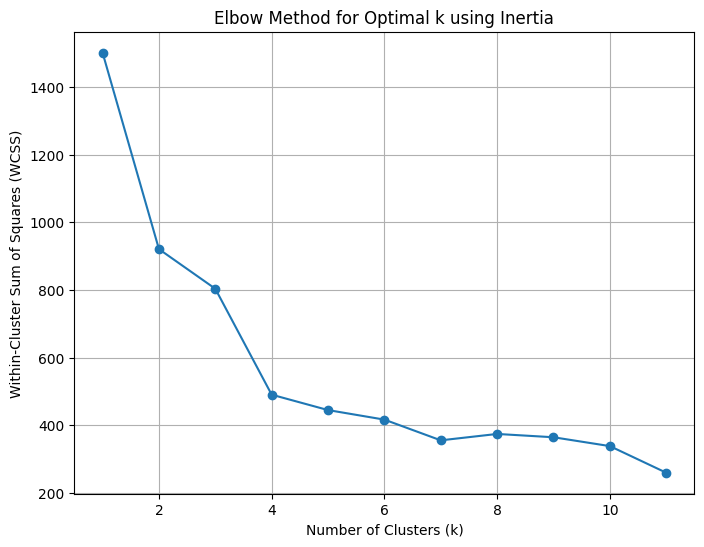

In [66]:


#amount of clusters, we want to check for
k_values = range(1, 12)

# Initialize an empty list to store the values for each value of k-means
wcss = []

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels, inertia = kmeans.fit_predict(data)
    wcss.append(inertia)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k using Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.savefig('elbow_inertia')
plt.show()



### Elbow method for sklearn

C:\Users\Inga\anaconda3\envs\datamining\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Inga\anaconda3\envs\datamining\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Inga\anaconda3\envs\datamining\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Inga\anaconda3\envs\datamining\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_

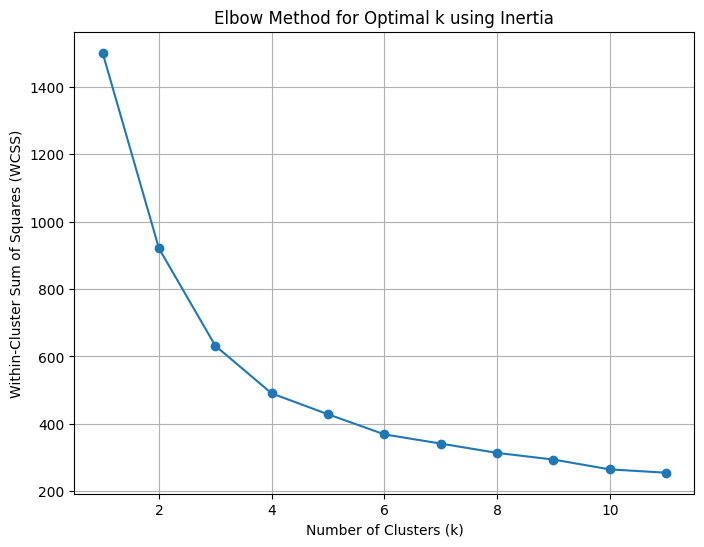

In [67]:

#amount of clusters, we want to check for
k_values = range(1, 12)

# Initialize an empty list to store the values for each value of k-means
wcss = []

# Calculate WCSS for each k
for k in k_values:
    kmeans_comp = SKLKMeans(n_clusters=k)
    labels = kmeans_comp.fit_predict(data)
    inertia_comp = kmeans_comp.inertia_
    wcss.append(inertia_comp)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k using Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.savefig('elbow_inertia_sklearn')
plt.show()
